# Freelancer Earnings vs Skill Stack



# Import Libraries

In [34]:
# General Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Models Libraries
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

sns.set_style("whitegrid")
sns.set_context("talk")   # makes text larger and cleaner
sns.set_theme(style="ticks", palette="deep")

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load dataset
Run this cell, by choosing this file:
`freelancer_earnings - freelancer_earnings_vs_skillstack_dataset.csv`

In [17]:
df = pd.read_csv("/content/drive/MyDrive/dataset/freelancer_earnings - freelancer_earnings_vs_skillstack_dataset.csv")

# To see all the columns in the data
pd.set_option('display.max_columns', None)
df.head()


,freelancer_id,category,primary_skills,years_experience,experience_level,region,country,education,hourly_rate_usd,annual_income_usd,primary_platform
0,FL0001,AI/ML Engineering,"Computer Vision, TensorFlow, Data Science",1.6,junior,Middle East,Israel,Master,66.41,"$58,873.61",Direct Client
1,FL0002,Backend Development,"PHP, Ruby, Go",8.3,senior,Middle East,UAE,Bootcamp,112.79,"$108,183.05",Freelancer
2,FL0003,UI/UX Design,"Sketch, Wireframing, Adobe XD",3.6,mid,North America,US,Self-taught,94.21,"$88,681.22",Freelancer
3,FL0004,DevOps,"Kubernetes, Terraform, AWS",2.3,mid,North America,US,Self-taught,118.87,"$109,229.42",Upwork
4,FL0005,DevOps,"Azure, Docker, Kubernetes",8.8,senior,Latin America,Mexico,Self-taught,82.76,"$66,298.22",LinkedIn


In [18]:
# Quick check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   freelancer_id      500 non-null    object 
 1   category           500 non-null    object 
 2   primary_skills     500 non-null    object 
 3   years_experience   500 non-null    float64
 4   experience_level   500 non-null    object 
 5   region             500 non-null    object 
 6   country            500 non-null    object 
 7   education          500 non-null    object 
 8   hourly_rate_usd    500 non-null    float64
 9   annual_income_usd  500 non-null    object 
 10  primary_platform   500 non-null    object 
dtypes: float64(2), object(9)
memory usage: 43.1+ KB


## Imports + cleaning helpers
We will:
- Convert annual income from $-strings to a numeric column
- Split `primary_skills` into a Python list
- Create `skill_count` = number of skills per freelancer

In [19]:
def parse_money(x):
    if pd.isna(x):
        return np.nan
    s=str(x).replace("$","").replace(",","").strip()
    try:
        return float(s)
    except:
        return np.nan

def split_skills(s):
    if pd.isna(s):
        return []
    return [x.strip() for x in str(s).split(",") if x.strip()]

df["annual_income_usd_num"] = df["annual_income_usd"].apply(parse_money)
df["skills_list"] = df["primary_skills"].apply(split_skills)
df["skill_count"] = df["skills_list"].apply(len)

df[["primary_skills","skills_list","skill_count","annual_income_usd","annual_income_usd_num"]].head()


,primary_skills,skills_list,skill_count,annual_income_usd,annual_income_usd_num
0,"Computer Vision, TensorFlow, Data Science","[Computer Vision, TensorFlow, Data Science]",3,"$58,873.61",58873.61
1,"PHP, Ruby, Go","[PHP, Ruby, Go]",3,"$108,183.05",108183.05
2,"Sketch, Wireframing, Adobe XD","[Sketch, Wireframing, Adobe XD]",3,"$88,681.22",88681.22
3,"Kubernetes, Terraform, AWS","[Kubernetes, Terraform, AWS]",3,"$109,229.42",109229.42
4,"Azure, Docker, Kubernetes","[Azure, Docker, Kubernetes]",3,"$66,298.22",66298.22


In [21]:
# after adding new columns
df.head()

,freelancer_id,category,primary_skills,years_experience,experience_level,region,country,education,hourly_rate_usd,annual_income_usd,primary_platform,annual_income_usd_num,skills_list,skill_count
0,FL0001,AI/ML Engineering,"Computer Vision, TensorFlow, Data Science",1.6,junior,Middle East,Israel,Master,66.41,"$58,873.61",Direct Client,58873.61,"[Computer Vision, TensorFlow, Data Science]",3
1,FL0002,Backend Development,"PHP, Ruby, Go",8.3,senior,Middle East,UAE,Bootcamp,112.79,"$108,183.05",Freelancer,108183.05,"[PHP, Ruby, Go]",3
2,FL0003,UI/UX Design,"Sketch, Wireframing, Adobe XD",3.6,mid,North America,US,Self-taught,94.21,"$88,681.22",Freelancer,88681.22,"[Sketch, Wireframing, Adobe XD]",3
3,FL0004,DevOps,"Kubernetes, Terraform, AWS",2.3,mid,North America,US,Self-taught,118.87,"$109,229.42",Upwork,109229.42,"[Kubernetes, Terraform, AWS]",3
4,FL0005,DevOps,"Azure, Docker, Kubernetes",8.8,senior,Latin America,Mexico,Self-taught,82.76,"$66,298.22",LinkedIn,66298.22,"[Azure, Docker, Kubernetes]",3


## Compulsory EDA
### Shape, missing values, duplicates, dtypes

In [27]:
print("Shape:", df.shape)

print("\nMissing values (%):")
print((df.isna().mean()*100).sort_values(ascending=False).head(20))

cols_no_list = df.columns.difference(["skills_list"])
print("\nDuplicate rows (excluding skills_list):", df.duplicated(subset=cols_no_list).sum())

print("\nDtypes:")
print(df.dtypes)


Shape: (500, 14)

Missing values (%):
freelancer_id            0.0
category                 0.0
primary_skills           0.0
years_experience         0.0
experience_level         0.0
region                   0.0
country                  0.0
education                0.0
hourly_rate_usd          0.0
annual_income_usd        0.0
primary_platform         0.0
annual_income_usd_num    0.0
skills_list              0.0
skill_count              0.0
dtype: float64

Duplicate rows (excluding skills_list): 0

Dtypes:
freelancer_id             object
category                  object
primary_skills            object
years_experience         float64
experience_level          object
region                    object
country                   object
education                 object
hourly_rate_usd          float64
annual_income_usd         object
primary_platform          object
annual_income_usd_num    float64
skills_list               object
skill_count                int64
dtype: object


### Numeric summary (stats)

In [28]:
num_cols = ["years_experience","hourly_rate_usd","annual_income_usd_num","skill_count"]
df[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
years_experience,500.0,5.85000,2.934779,0.50,3.6000,5.600,7.8000,14.00
hourly_rate_usd,500.0,97.14982,52.697831,17.28,55.1825,84.445,130.4975,281.47
annual_income_usd_num,500.0,91299.02830,50378.426293,16236.64,52694.8650,78405.365,123443.5550,275012.36
skill_count,500.0,3.00000,0.000000,3.00,3.0000,3.000,3.0000,3.00


### Distributions (continuous variables)
- Years of experience
- Hourly rate
- Annual income
- Skill count

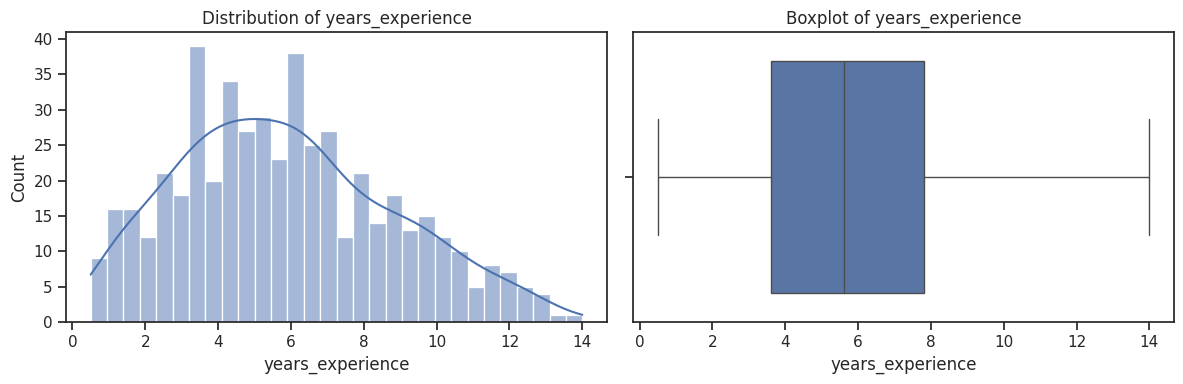

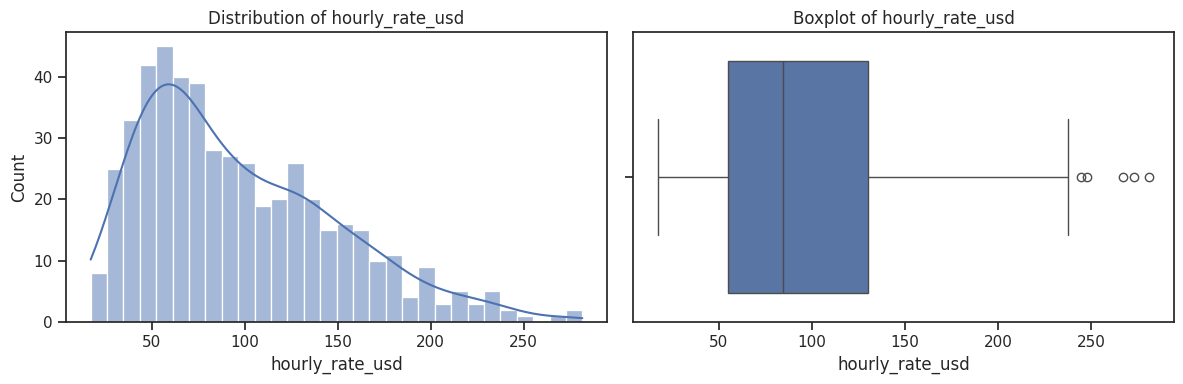

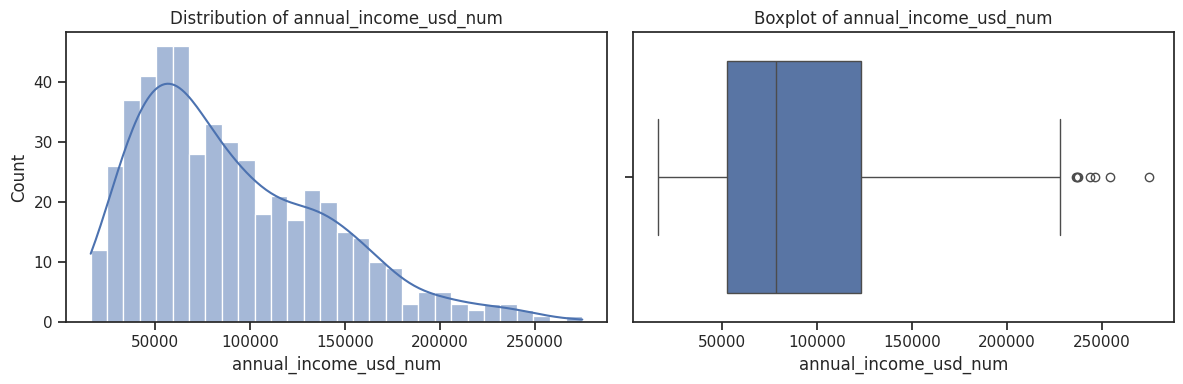

In [35]:
for col in ["years_experience","hourly_rate_usd","annual_income_usd_num"]:

    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    sns.histplot(df[col], bins=30, kde=True, ax=axes[0])
    axes[0].set_title(f"Distribution of {col}")

    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()

### Relationship plot: Hourly rate vs experience

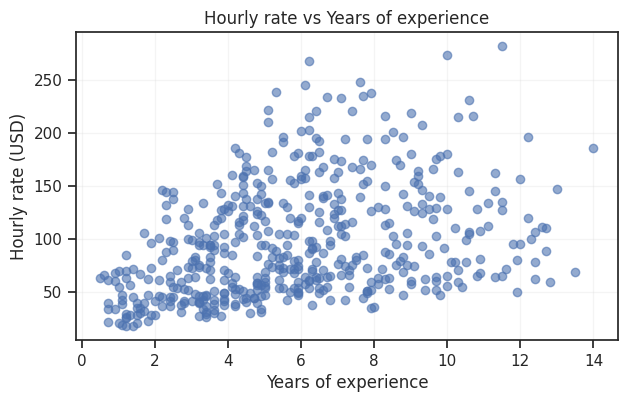

In [37]:
plt.figure(figsize=(7,4))
plt.scatter(df["years_experience"], df["hourly_rate_usd"], alpha=0.6)
plt.title("Hourly rate vs Years of experience")
plt.xlabel("Years of experience")
plt.ylabel("Hourly rate (USD)")
plt.grid(True, alpha=0.2)
plt.show()


### Categorical counts (discrete variables)
This shows how many freelancers exist in each group.

In [38]:
cat_cols = ["category","experience_level","region","country","education","primary_platform"]
for c in cat_cols:
    print("\n", c)
    display(df[c].value_counts().head(15))



 category


,count
category,
Cybersecurity,68
DevOps,58
Web Development,58
Full Stack,51
UI/UX Design,48
Blockchain,46
Backend Development,45
AI/ML Engineering,45
Data Engineering,45



 experience_level


,count
experience_level,
senior,279
mid,175
junior,46



 region


,count
region,
Eastern Europe,84
Middle East,81
Western Europe,72
Africa,72
Latin America,69
North America,63
Asia Pacific,59



 country


,count
country,
Israel,42
UAE,39
US,39
South Africa,36
Nigeria,36
Ukraine,31
Romania,28
Poland,25
Brazil,24



 education


,count
education,
Bachelor,187
Master,139
Self-taught,112
Bootcamp,38
PhD,24



 primary_platform


,count
primary_platform,
Direct Client,143
Upwork,120
Freelancer,71
LinkedIn,59
Toptal,54
Fiverr,43
Other,10


## Advanced EDA: Skills (discrete)
We **explode** skills into one row per skill to compute:
- Most famous skills (most common)
- High paying skills (avg hourly), with a minimum freelancer threshold


In [39]:
skills_exploded = df[["freelancer_id","skills_list","hourly_rate_usd","annual_income_usd_num","years_experience"]].explode("skills_list")
skills_exploded = skills_exploded.rename(columns={"skills_list":"skill"})
skills_exploded = skills_exploded[skills_exploded["skill"].notna() & (skills_exploded["skill"]!="")]

skill_stats = skills_exploded.groupby("skill").agg(
    freelancers=("freelancer_id","nunique"),
    avg_hourly=("hourly_rate_usd","mean"),
    median_hourly=("hourly_rate_usd","median"),
    avg_annual=("annual_income_usd_num","mean"),
    avg_experience=("years_experience","mean")
).sort_values(["freelancers","avg_hourly"], ascending=[False, False])

skill_stats.head(20)


,freelancers,avg_hourly,median_hourly,avg_annual,avg_experience
skill,,,,,
Python,68,105.588382,96.380,101181.782500,6.000000
React,62,86.310645,77.215,79915.719677,5.937097
Cryptography,58,116.966207,105.855,109240.645000,5.736207
Node.js,54,85.129630,78.920,79955.029444,5.944444
Penetration Testing,51,107.628235,97.410,101239.897647,5.684314
Security Audit,50,113.198400,97.855,105635.761000,6.212000
Network Security,45,115.320222,107.040,107440.230000,6.028889
Smart Contracts,32,121.623125,105.820,114969.120000,6.200000
Ethereum,32,112.459063,105.820,106010.527500,5.715625


### Plot: Top 20 most common skills

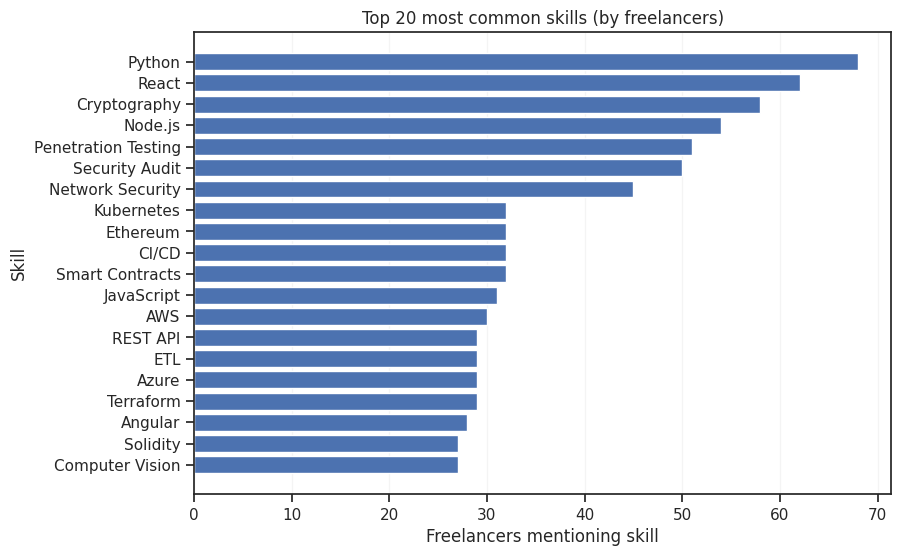

In [40]:
top_pop = skill_stats.head(20).sort_values("freelancers")
plt.figure(figsize=(9,6))
plt.barh(top_pop.index, top_pop["freelancers"])
plt.title("Top 20 most common skills (by freelancers)")
plt.xlabel("Freelancers mentioning skill")
plt.ylabel("Skill")
plt.grid(True, axis="x", alpha=0.2)
plt.show()


### Plot: Top 20 highest-paying skills (avg hourly)
We apply `threshold = 5` freelancers to avoid noisy one-offs.

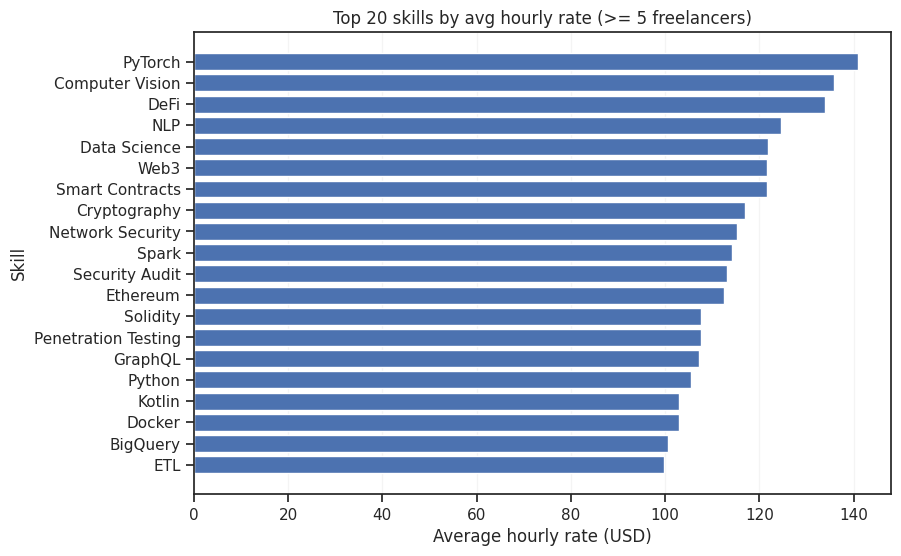

In [41]:
threshold = 5
top_pay = (skill_stats[skill_stats["freelancers"]>=threshold]
          .sort_values("avg_hourly", ascending=False)
          .head(20)
          .sort_values("avg_hourly"))

plt.figure(figsize=(9,6))
plt.barh(top_pay.index, top_pay["avg_hourly"])
plt.title(f"Top 20 skills by avg hourly rate (>= {threshold} freelancers)")
plt.xlabel("Average hourly rate (USD)")
plt.ylabel("Skill")
plt.grid(True, axis="x", alpha=0.2)
plt.show()


## Modeling setup
Target: **hourly_rate_usd** (earning power proxy)

Features used:
- years_experience
- category, experience_level, region, country, education, primary_platform
- skills_list (multi-hot encoding of top-N skills)

**Important:** We drop annual income columns when predicting hourly rate to avoid leakage.

In [42]:
class TopSkillBinarizer(BaseEstimator, TransformerMixin):
    # Convert a list of skills into a multi-hot matrix using top-N skills from training set
    def __init__(self, top_n=80):
        self.top_n = top_n

    def fit(self, X, y=None):
        col = X.iloc[:,0]
        counts = {}
        for lst in col:
            for s in (lst or []):
                counts[s] = counts.get(s, 0) + 1
        top = sorted(counts.items(), key=lambda kv: (-kv[1], kv[0]))[:self.top_n]
        self.skills_ = [k for k, v in top]
        self.skill_to_idx_ = {s:i for i,s in enumerate(self.skills_)}
        return self

    def transform(self, X):
        col = X.iloc[:,0]
        out = np.zeros((len(col), len(self.skills_)), dtype=np.float32)
        for i, lst in enumerate(col):
            for s in (lst or []):
                j = self.skill_to_idx_.get(s)
                if j is not None:
                    out[i, j] = 1.0
        return out

    def get_feature_names_out(self, input_features=None):
        return np.array([f"skill__{s}" for s in self.skills_])

y = df["hourly_rate_usd"].astype(float)

X = df.drop(columns=[
    "hourly_rate_usd",
    "annual_income_usd", "annual_income_usd_num",
    "primary_skills",
    "freelancer_id"
])

skill_col = ["skills_list"]
numeric_cols = ["years_experience"]
cat_cols = ["category","experience_level","region","country","education","primary_platform"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("scaler", StandardScaler())]), numeric_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
        ("skills", Pipeline([("bin", TopSkillBinarizer(top_n=80))]), skill_col),
    ],
    verbose_feature_names_out=False
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Train Models + evaluate
Models:
- Ridge
- Random Forest
- Gradient Boosting

Metrics:
- MAE (lower is better)
- RMSE (lower is better)
- R² (higher is better)

In [43]:
def evaluate(pipe):
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    return {
        "MAE": mean_absolute_error(y_test, pred),
        "RMSE": (mean_squared_error(y_test, pred) ** 0.5),
        "R2": r2_score(y_test, pred)
    }

pipes = {
    "Ridge": Pipeline([("prep", preprocess), ("model", Ridge(random_state=42))]),
    "RandomForest": Pipeline([("prep", preprocess), ("model", RandomForestRegressor(
        random_state=42, n_estimators=300, n_jobs=-1
    ))]),
    "GradientBoosting": Pipeline([("prep", preprocess), ("model", GradientBoostingRegressor(random_state=42))]),
}

results=[]
for name, pipe in pipes.items():
    results.append({"model": name, **evaluate(pipe)})

results_df = pd.DataFrame(results).sort_values("RMSE")
results_df


,model,MAE,RMSE,R2
2,GradientBoosting,11.930852,17.425029,0.889517
0,Ridge,15.125609,20.627035,0.845181
1,RandomForest,14.043939,21.428027,0.832924


## Feature importance (top features + top skills)
We use Gradient Boosting feature importances.

This answers:
- Which features matter most overall?
- Which *skills* matter most for higher hourly rate?

In [44]:
gb_pipe = pipes["GradientBoosting"]
gb_pipe.fit(X_train, y_train)

feat_names = gb_pipe.named_steps["prep"].get_feature_names_out()
importances = gb_pipe.named_steps["model"].feature_importances_

feat_imp = (pd.DataFrame({"feature": feat_names, "importance": importances})
            .sort_values("importance", ascending=False))

print("Top 30 overall features:")
display(feat_imp.head(30))

print("\nTop 25 skill features:")
display(feat_imp[feat_imp["feature"].str.startswith("skill__")].head(25))


Top 30 overall features:


,feature,importance
20,region_Western Europe,0.189408
0,years_experience,0.143808
19,region_North America,0.101344
18,region_Middle East,0.089354
14,region_Africa,0.071075
13,experience_level_senior,0.067707
22,country_Australia,0.056986
41,country_US,0.050005
17,region_Latin America,0.031636
9,category_UI/UX Design,0.021117



Top 25 skill features:


,feature,importance
56,skill__Cryptography,0.010236
61,skill__Network Security,0.007442
73,skill__Web3,0.004351
74,skill__Computer Vision,0.004203
58,skill__React,0.001611
91,skill__DeFi,0.001537
88,skill__NLP,0.001231
62,skill__Smart Contracts,0.001143
78,skill__Sketch,0.001136
57,skill__Node.js,0.000994


## Hyperparameter tuning
We do a simple validation split, then search:
- Ridge alpha
- Gradient Boosting: n_estimators, learning_rate, max_depth, subsample

Finally, we evaluate the tuned models on the test set.

In [45]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

def val_mae(pipe):
    pipe.fit(X_tr, y_tr)
    pred = pipe.predict(X_val)
    return mean_absolute_error(y_val, pred)

# Ridge alpha search
alphas = np.logspace(-3, 3, 18)
best_alpha, best_mae = None, 1e9
for a in alphas:
    p = Pipeline([("prep", preprocess), ("model", Ridge(alpha=a, random_state=42))])
    mae = val_mae(p)
    if mae < best_mae:
        best_alpha, best_mae = a, mae

print("Best Ridge alpha:", best_alpha, "| val MAE:", best_mae)

# Gradient Boosting small grid
best_gb, best_gb_mae = None, 1e9
for n in [150, 250, 400]:
    for lr in [0.03, 0.05, 0.08, 0.1]:
        for md in [2,3,4]:
            for ss in [0.7, 1.0]:
                p = Pipeline([("prep", preprocess), ("model", GradientBoostingRegressor(
                    random_state=42, n_estimators=n, learning_rate=lr, max_depth=md, subsample=ss
                ))])
                mae = val_mae(p)
                if mae < best_gb_mae:
                    best_gb, best_gb_mae = (n, lr, md, ss), mae

print("Best GB params (n, lr, depth, subsample):", best_gb, "| val MAE:", best_gb_mae)

# Evaluate tuned models on test set
ridge_tuned = Pipeline([("prep", preprocess), ("model", Ridge(alpha=best_alpha, random_state=42))])
gb_tuned = Pipeline([("prep", preprocess), ("model", GradientBoostingRegressor(
    random_state=42, n_estimators=best_gb[0], learning_rate=best_gb[1], max_depth=best_gb[2], subsample=best_gb[3]
))])

for name, p in [("Ridge (tuned)", ridge_tuned), ("GradientBoosting (tuned)", gb_tuned)]:
    p.fit(X_train, y_train)
    pred = p.predict(X_test)
    print("\n", name)
    print("MAE :", mean_absolute_error(y_test, pred))
    print("RMSE:", (mean_squared_error(y_test, pred) ** 0.5))
    print("R2  :", r2_score(y_test, pred))


Best Ridge alpha: 0.6660846290809161 | val MAE: 13.783191867698458
Best GB params (n, lr, depth, subsample): (400, 0.08, 2, 0.7) | val MAE: 11.352832694742224

 Ridge (tuned)
MAE : 15.220016354194113
RMSE: 20.668085591541644
R2  : 0.8445645410308381

 GradientBoosting (tuned)
MAE : 11.916116342000201
RMSE: 17.058119356840155
R2  : 0.8941204968014715
